# Train a model for classifying tissue samples into benign vs malign

## Import needed libraries

In [23]:
import urllib.request
import os
import tarfile
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

## Get the data ready

### Download the images

In [ ]:
# Download the 56 zip files in Images_png in batches
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]


for idx, link in enumerate(links):
    fn = '/home/crisrbarreram/Documents/ccir_demo/imgs/images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file


print("Download complete. Please check the checksums")

### Define the paths

In [2]:
# Paths
data_dir = '/home/crisrbarreram/Documents/ccir_demo/imgs/'
csv_path = '/home/crisrbarreram/Documents/ccir_demo/Data_Entry_2017_v2020.csv'
output_dir = '/home/crisrbarreram/Documents/ccir_demo/processed/'
image_dir = '/home/crisrbarreram/Documents/ccir_demo/imgs/images/'

### Unpack the files

In [ ]:
# Unpack all .tar.gz files into individual subdirectories
tar_files = [f for f in os.listdir(data_dir) if f.endswith('.tar.gz')]
for tar_file in tar_files:
    tar_path = os.path.join(data_dir, tar_file)
    subdir = os.path.join(data_dir, tar_file[:-7])  # Create subdirectory based on tar file name
    os.makedirs(subdir, exist_ok=True)
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=subdir)
    print(f'Unpacked {tar_file} into {subdir}')

In [ ]:
# Create directories for processed data
os.makedirs(os.path.join(output_dir, 'train/normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/pneumonia'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/pneumonia'), exist_ok=True)

### Load the csv file for identifying the labels for normal vs pneumonia

In [3]:
# Load CSV
df = pd.read_csv(csv_path)

### filter out for Pneumonia vs Normal

In [4]:
# Load CSV and filter images with labels 'No Finding' and 'Pneumonia'
df = pd.read_csv(csv_path)
filtered_df = df[df['Finding Labels'].isin(['No Finding', 'Pneumonia'])].copy()

# Map 'No Finding' to 'normal' and 'Pneumonia' to 'pneumonia'
filtered_df.loc[:, 'label'] = filtered_df['Finding Labels'].map({'No Finding': 'normal', 'Pneumonia': 'pneumonia'})


### Split into train and test

In [5]:
# Split into train and test sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['label'], random_state=42)

### copy images to corresponding folders

In [ ]:
# Function to copy images to their respective directories
def copy_images(df, split):
    for _, row in df.iterrows():
        label = row['label']
        image_path = os.path.join(image_dir, row['Image Index'])
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(output_dir, split, label, row['Image Index']))


# Copy images to train and test directories
copy_images(train_df, 'train')
copy_images(test_df, 'test')


print("Images have been successfully filtered and organized.")

## Image preprocessing and HOGs features

### Image preprocessing

In [6]:
# Image normalization and preprocessing function
def preprocess_image(image):
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    image = cv2.equalizeHist(image)  # Histogram equalization
    image = image / 255.0  # Normalize to [0, 1] range
    return image

### HOG descriptor

In [7]:
# HOG descriptor function
def hog_descriptors(images):
    hog_features = []
    for image in images:
        feature, hog_image = hog(image, visualize=True)
        hog_features.append((feature, hog_image))
    return hog_features

### Load images

In [8]:
# Load images, convert to grayscale, and preprocess
def load_images(image_dir):
    images = []
    for file_name in os.listdir(image_dir):
        if file_name.endswith('.png'):
            image_path = os.path.join(image_dir, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = preprocess_image(image)
            images.append(image)
    return np.array(images)

### Load training and testing images

In [9]:
train_normal_images = load_images(os.path.join(output_dir, 'train/normal'))
train_pneumonia_images = load_images(os.path.join(output_dir, 'train/pneumonia'))
test_normal_images = load_images(os.path.join(output_dir, 'test/normal'))
test_pneumonia_images = load_images(os.path.join(output_dir, 'test/pneumonia'))

### Combine images and labels

In [10]:
train_images = np.concatenate((train_normal_images, train_pneumonia_images))
train_labels = np.concatenate((np.zeros(len(train_normal_images)), np.ones(len(train_pneumonia_images))))
test_images = np.concatenate((test_normal_images, test_pneumonia_images))
test_labels = np.concatenate((np.zeros(len(test_normal_images)), np.ones(len(test_pneumonia_images))))

### Convert the training images to HOG descriptors

In [11]:
train_hog_features = hog_descriptors(train_images)
train_hog = np.array([feature for feature, _ in train_hog_features])

### Create a new SVM

In [12]:
svm = cv2.ml.SVM_create()

### Set the SVM kernel to RBF

In [13]:
svm.setKernel(cv2.ml.SVM_RBF)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setGamma(0.5)
svm.setC(12)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-6))

### Train the SVM on the set of training data

In [14]:
svm.train(train_hog.astype(np.float32), cv2.ml.ROW_SAMPLE, train_labels.astype(np.int32))

True

### Test the SVM

In [15]:
test_hog_features = hog_descriptors(test_images)
test_hog = np.array([feature for feature, _ in test_hog_features])
_, test_pred = svm.predict(test_hog.astype(np.float32))

### Evaluate the SVM

In [16]:
accuracy = np.mean(test_pred == test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 15.22%


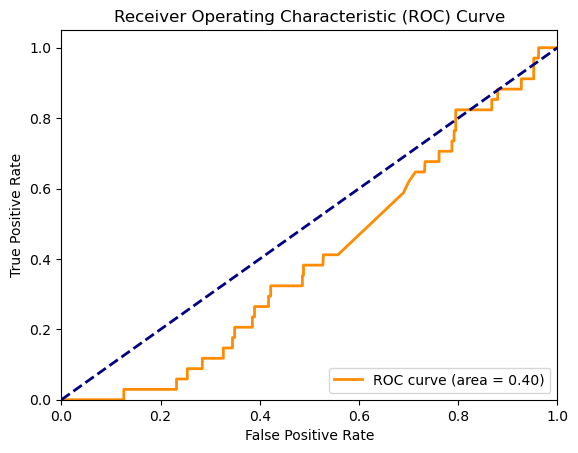

In [24]:
# Compute the ROC curve and AUC
test_labels_binary = (test_labels == 1).astype(np.int32)  # Convert labels to binary (1 for pneumonia, 0 for normal)
test_scores = svm.predict(test_hog.astype(np.float32), flags=cv2.ml.STAT_MODEL_RAW_OUTPUT)[1]
fpr, tpr, thresholds = roc_curve(test_labels_binary, test_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Display some results

In [17]:
# Display some results
def display_results(images, labels, predictions, hog_images, num_correct=2, num_incorrect=2):
    correct_normal = np.where((predictions == labels) & (labels == 0))[0]
    correct_pneumonia = np.where((predictions == labels) & (labels == 1))[0]
    incorrect_normal = np.where((predictions != labels) & (labels == 0))[0]
    incorrect_pneumonia = np.where((predictions != labels) & (labels == 1))[0]
    
    # Display correct predictions
    if len(correct_normal) > 0:
        idx = correct_normal[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Correct: Normal')
        plt.subplot(1, 2, 2)
        plt.imshow(hog_images[idx], cmap='gray')
        plt.title('HOG Features')
        plt.show()
    if len(correct_pneumonia) > 0:
        idx = correct_pneumonia[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Correct: Pneumonia')
        plt.subplot(1, 2, 2)
        plt.imshow(hog_images[idx], cmap='gray')
        plt.title('HOG Features')
        plt.show()
    
    # Display incorrect predictions
    if len(incorrect_normal) > 0:
        idx = incorrect_normal[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Incorrect: Predicted Pneumonia, Actual Normal')
        plt.subplot(1, 2, 2)
        plt.imshow(hog_images[idx], cmap='gray')
        plt.title('HOG Features')
        plt.show()
    if len(incorrect_pneumonia) > 0:
        idx = incorrect_pneumonia[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Incorrect: Predicted Normal, Actual Pneumonia')
        plt.subplot(1, 2, 2)
        plt.imshow(hog_images[idx], cmap='gray')
        plt.title('HOG Features')
        plt.show()

In [18]:
# Extract HOG images for visualization

In [19]:
test_hog_images = [hog_image for _, hog_image in test_hog_features]

In [20]:
### Display results

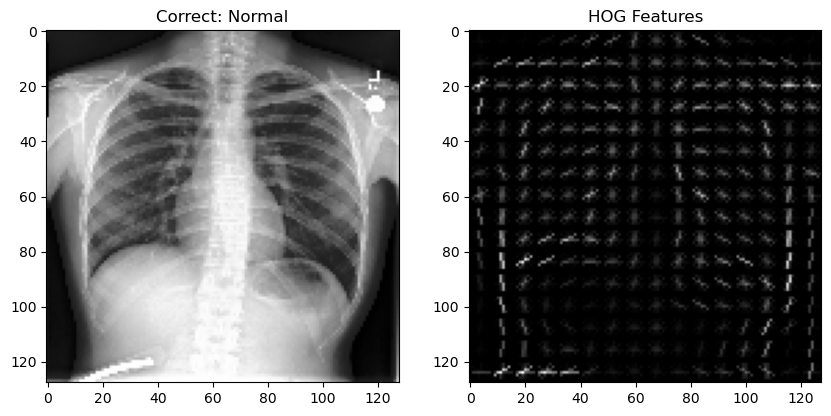

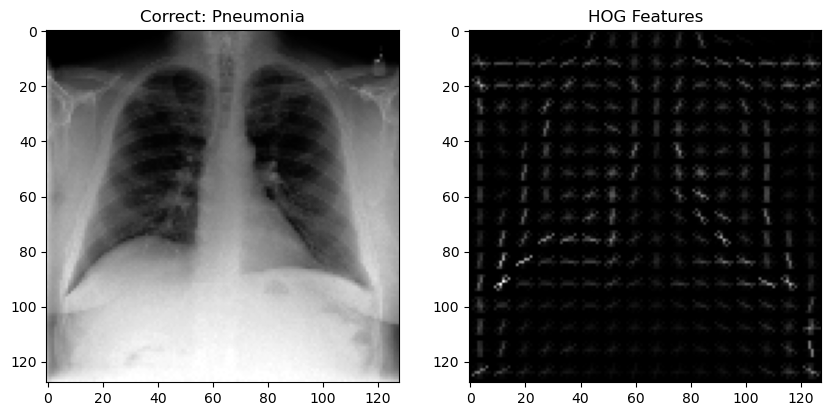

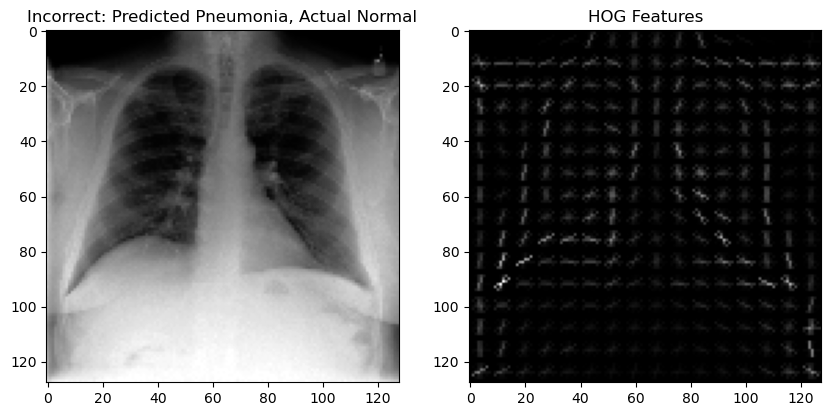

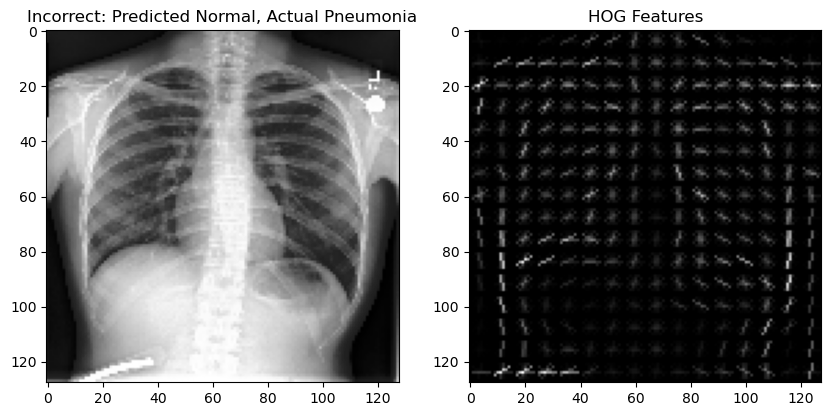

In [21]:
display_results(test_images, test_labels, test_pred, test_hog_images)